In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

import warnings  
warnings.filterwarnings('ignore')

# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from string import punctuation
import unidecode
%pip install imbalanced-learn

## Load data

each line corresponds to a wine and each column is an infomration about that wine. Since our aim is to classify grape variety, our target feature will be the variety column. We will use the description column, which is a characterisation by an expert, to determine to which target feature it belongs to. Another interesting study could be to identify wineries, country or province based on the description but we leave that for another time. The concepts laid down here could be applied there too.

In [6]:
data = pd.read_csv('winemag-data_first150k.csv')
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [7]:
data.shape

(150930, 11)

## Data Preprocessing

In [8]:
data_sel = data.drop(['Unnamed: 0','designation','points','region_2',], axis = 1)
data.shape

(150930, 11)

We do not want any duplication in the description column since that might falsely over emphasize certain features. Therefore, we start by dropping any description duplicates.

In [10]:
data_single = data_sel.drop_duplicates('description')
data_single.shape

(97821, 7)

In [11]:
data_single = data_single.dropna(subset=['description', 'variety', 'price'])
data_single.shape

(89108, 7)

In [12]:
data_single.head()

,country,description,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude


In [13]:
data_single.describe(include='all')

,country,description,price,province,region_1,variety,winery
count,89105,89108,89108.000000,89105,74587,89108,89108
unique,46,89108,NaN,446,1197,619,13852
top,US,This tremendous 100% varietal wine hails from ...,NaN,California,Napa Valley,Pinot Noir,Williams Selyem
freq,40338,1,NaN,28672,4112,8802,233
mean,NaN,NaN,33.659077,NaN,NaN,NaN,NaN
std,NaN,NaN,37.667717,NaN,NaN,NaN,NaN
min,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,16.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,25.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,40.000000,NaN,NaN,NaN,NaN


We have left country, province, region_1 and winery in as features, because they will serve as stop words to be removed from the description column, to try to decrease the chance of having any hints in the description about grape type. The price could be used as a feature to predict grape types, but we will not use it here. You could change our code and try it if you wish. We have printed a summary of the data frame too. We can see that the number of samples in description, variety and price match, which is a good sign, meaning they should be unique inputs. It seems there are NAs in country, province and region_1. There are 619 unique grape varieties, pinot noir being the most frequent, having 8802 inputs. The price range is quite wide. Would you pay $2300 for a bottle of wine? The next thing we do is to transform all text into lower case letters and remove any accents from letters.

In [14]:
for col in ['variety', 'description', 'province', 'region_1', 'winery', 'country']:
    data_single[col] = data_single[col].str.lower()

In [16]:
def unidecode_text(text):
    try:
        #pdb.set_trace()
        text = unidecode.unidecode(text)
    except:
        pass
    return text

In [17]:
for col in ['description', 'variety', 'province', 'winery']:
    data_single[col] = data_single.apply(lambda row: unidecode_text(row[col]), axis=1)

data_single.head(5)

,country,description,price,province,region_1,variety,winery
0,us,this tremendous 100% varietal wine hails from ...,235.0,california,napa valley,cabernet sauvignon,heitz
1,spain,"ripe aromas of fig, blackberry and cassis are ...",110.0,northern spain,toro,tinta de toro,bodega carmen rodriguez
2,us,mac watson honors the memory of a wine once ma...,90.0,california,knights valley,sauvignon blanc,macauley
3,us,"this spent 20 months in 30% new french oak, an...",65.0,oregon,willamette valley,pinot noir,ponzi
4,france,"this is the top wine from la begude, named aft...",66.0,provence,bandol,provence red blend,domaine de la begude


***Target feature processing***

By looking at the feature target, varieties, we can find out that there are 619 varieties, each one having different number of inputs, many of them having only one. Certainly, the latter ones will not be of use, because we will not be able to train and test on one sample. Later on we will set a limit on how many samples a variety has to have.

In [18]:
data_single.variety.value_counts()

pinot noir            8802
chardonnay            8696
cabernet sauvignon    8182
red blend             6073
sauvignon blanc       3871
                      ... 
kinali yapincak          1
saperavi-merlot          1
torontel                 1
chinuri                  1
carnelian                1
Name: variety, Length: 619, dtype: int64

We can see many blend wines. A blended wine refers to a mixture of different grapes (not necessarily having a concensus on what grapes are included). We find it too ambitious to have a classifier that could correctly identify these wines, therefore we simply remove those samples that are labelled blends. Also, there are roses too, without any reference to the type of the grape it was produced. That is why we will remove roses too. Below you find a list of labels we will remove from the variety column.

In [19]:
filtered_name = ['red blend', 'portuguese red', 'white blend', 'sparkling blend', 'champagne blend', 
                 'portuguese white', 'rose', 'bordeaux-style red blend', 'rhone-style red blend',
                 'bordeaux-style white blend', 'alsace white blend', 'austrian red blend',
                 'austrian white blend', 'cabernet blend', 'malbec blend', 'portuguese rose',
                 'portuguese sparkling', 'provence red blend', 'provence white blend',
                 'rhone-style white blend', 'tempranillo blend', 'grenache blend',
                 'meritage' # beaurdaux blend
                ]

In [20]:
data_filtered = data_single.copy()
data_filtered = data_filtered[~data_filtered['variety'].isin(filtered_name)]

Our next task is to bring the variety names on a common ground. Different countries have different names for the same grape, so we should categorize them in the same way. For example trebbiano and ugni blanc is the same grape. Therefore, we make a mapping between certain names and their common name.

In [21]:
def correct_grape_names(row):
    regexp = [r'shiraz', r'ugni blanc', r'cinsaut', r'carinyena', r'^ribolla$', r'palomino', r'turbiana', r'verdelho', r'viura', r'pinot bianco|weissburgunder', r'garganega|grecanico', r'moscatel', r'moscato', r'melon de bourgogne', r'trajadura|trincadeira', r'cannonau|garnacha', r'grauburgunder|pinot grigio', r'pinot noir|pinot nero', r'colorino', r'mataro|monastrell', r'mourv(\w+)']
    grapename = ['syrah', 'trebbiano', 'cinsault', 'carignan', 'ribolla gialla', 'palomino','verdicchio', 'verdejo','macabeo', 'pinot blanc', 'garganega', 'muscatel', 'muscat', 'muscadet', 'treixadura', 'grenache', 'pinot gris', 'pinot noir', 'lambrusco', 'mourvedre', 'mourvedre']
    f = row
    for exsearch, gname in zip(regexp, grapename):
        f = re.sub(exsearch, gname, f)
    return f

name_pairs = [('spatburgunder', 'pinot noir'), ('garnacha', 'grenache'), ('pinot nero', 'pinot noir'),
              ('alvarinho', 'albarino'), ('assyrtico', 'assyrtiko'), ('black muscat', 'muscat hamburg'),
              ('kekfrankos', 'blaufrankisch'), ('garnacha blanca', 'grenache blanc'),
              ('garnacha tintorera', 'alicante bouschet'), ('sangiovese grosso', 'sangiovese')
             ]

In [22]:
data_corrected = data_filtered.copy()
data_corrected['variety'] = data_corrected['variety'].apply(lambda row: correct_grape_names(row))
for start, end in name_pairs:
    data_corrected['variety'] = data_corrected['variety'].replace(start, end) 

In [23]:
len(data_corrected.variety.value_counts())

557

Visibly, we have now only 557 different grape types (and still there might be several references to the same grape under different names). Now we filter out any grape variety that has less than 200 samples in the data base.

In [24]:
data_reduced = data_corrected.groupby('variety').filter(lambda x: len(x) > 200)
data_reduced.shape

(62087, 7)

In [25]:
data_reduced.variety.value_counts()

pinot noir                       8925
chardonnay                       8696
cabernet sauvignon               8182
syrah                            4807
sauvignon blanc                  3871
riesling                         3384
merlot                           3131
sangiovese                       2489
zinfandel                        2403
malbec                           1910
pinot gris                       1644
tempranillo                      1602
nebbiolo                          966
corvina, rondinella, molinara     868
viognier                          851
cabernet franc                    848
grenache                          664
gewurztraminer                    618
petite sirah                      584
gruner veltliner                  578
port                              539
barbera                           488
carmenere                         488
albarino                          404
muscat                            402
chenin blanc                      396
pinot blanc 

Now we have only 62 087 inputs and 35 grape labels. As you can see the number of samples for each grape is very imbalanced which actually has a great implication on the performance of the classifier

In [27]:
grapes = list(np.unique(data_reduced.variety.value_counts().index.tolist()))
grapes

['aglianico',
 'albarino',
 'barbera',
 'cabernet franc',
 'cabernet sauvignon',
 'carmenere',
 'chardonnay',
 'chenin blanc',
 'corvina, rondinella, molinara',
 'gamay',
 'gewurztraminer',
 'glera',
 'grenache',
 'gruner veltliner',
 'malbec',
 'merlot',
 'mourvedre',
 'muscat',
 'nebbiolo',
 "nero d'avola",
 'petite sirah',
 'pinot blanc',
 'pinot gris',
 'pinot noir',
 'port',
 'prosecco',
 'riesling',
 'sangiovese',
 'sauvignon blanc',
 'syrah',
 'tempranillo',
 'torrontes',
 'verdejo',
 'viognier',
 'zinfandel']

In [28]:
len(grapes)

35

***Introduction of new features***

During blind tasting wine experts are allowed to look and expect the wine, but the wine label is not exposed to them. Therefore, we introduce the colour feature of the selected grapes.

In [29]:
colour_map = {'aglianico': 'red', 'albarino': 'white', 'barbera': 'red', 'cabernet franc': 'red',
              'cabernet sauvignon': 'red', 'carmenere': 'red', 'chardonnay': 'white', 'chenin blanc': 'white',
              'corvina, rondinella, molinara': 'red', 'gamay': 'red', 'garganega': 'white', 
              'gewurztraminer': 'white', 'glera': 'white', 'grenache': 'red', 'gruner veltliner': 'white',
              'malbec': 'red', 'merlot': 'red', 'mourvedre': 'red', 'muscat': 'white', 'nebbiolo': 'red',
              "nero d'avola": 'red', 'petite sirah': 'red', 'pinot blanc': 'white', 'pinot gris': 'white',
              'pinot noir': 'red', 'port': 'red', 'prosecco': 'white', 'riesling': 'white', 'sangiovese': 'red',
              'sauvignon blanc': 'white', 'syrah': 'red', 'tempranillo': 'red', 'torrontes': 'white', 
              'verdejo': 'white', 'viognier': 'white', 'zinfandel': 'white'
             }

We create two more columns with names red and white, and their values can be 1 if the wine has that colour or 0 if it does not. In sklearn this corresponds to one hot incoding, we transform categorical data into vectors.

In [30]:
kaggle_input = data_reduced.copy()
kaggle_input['colour'] = kaggle_input.apply(lambda row: colour_map[row['variety']], axis=1)
colour_dummies = pd.get_dummies(kaggle_input['colour'])
kaggle_input = kaggle_input.merge(colour_dummies, left_index=True, right_index=True)

In [31]:
kaggle_input.reset_index(inplace=True)
kaggle_input.head()

,index,country,description,price,province,region_1,variety,winery,colour,red,white
0,0,us,this tremendous 100% varietal wine hails from ...,235.0,california,napa valley,cabernet sauvignon,heitz,red,1,0
1,2,us,mac watson honors the memory of a wine once ma...,90.0,california,knights valley,sauvignon blanc,macauley,white,0,1
2,3,us,"this spent 20 months in 30% new french oak, an...",65.0,oregon,willamette valley,pinot noir,ponzi,red,1,0
3,8,us,this re-named vineyard was formerly bottled as...,65.0,oregon,chehalem mountains,pinot noir,bergstrom,red,1,0
4,9,us,the producer sources from two blocks of the vi...,60.0,california,sonoma coast,pinot noir,blue farm,red,1,0


## Building the classification model

Now that we are ready with the data preprocessing wwe start to build up the model for classification. We start with steps to build a text vectorizer, define a XGBoost classifier and put everything into a pipeline which deals with selecting text based and numerical based inputs separately.

***Stop words***

These are words that we do not want to come accross in the text and do not want to analyse them. That is why we remove any occurance of the country, province and winery from the text.

In [32]:
# stop words for countries
stop_country = list(np.unique(kaggle_input.country.dropna().str.lower().tolist()))

#stop words for province
stop_province = list(np.unique(kaggle_input.province.dropna().str.lower().tolist()))

#stop words for winery
stop_winery = list(np.unique(kaggle_input.winery.dropna().str.lower().tolist()))

We load in the stop words of nltk too. That has a good collection of filling words that are usually not descriptive for a text. We additionally extend that with our self defined list of punctuations and a few words.

In [38]:
# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')

In [39]:
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop_words1 = stop_words + stop_append + grapes + stop_country + stop_province + stop_winery

***POS tagging and Lemma tokenization***

In the description text a word might appear in different forms while actually representing the same word, like good and best. To reduce noise we try to find the basic form (lemma) of each word in the text. We will rely on the nltk package to achieve this, but first we have to type tag each word, wether they are nouns, verbs, adjectives or adverbs. For that we built up some helper functions.

In [84]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.corpus.wordnet.ADJ
    elif is_noun(tag):
        return nltk.corpus.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.corpus.wordnet.ADV
    elif is_verb(tag):
        return nltk.corpus.wordnet.VERB
    return nltk.corpus.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

We created a class for lemmatization, LemmaTokenizer. Besides finding the lemmas it does some text filtering and at the end only selects nouns and adjectives, since these are the most descriptive words in the life of a wine.

***Text vectorizer***

To transform the text based description column into a number based object, we use term frequency-inverse document frequency (tf-idf) vectorization. First it counts the occurance of a word in one sample and than down-weighs it with the occurance of the same word over all the samples. It repeats this process for each word and outputs a vector of numbers, where each number represents a word. The actual vectorizer performes some firther normalization too. We have decided to analyse the text word by word (1-grams), but you could choose 2-grams or n-grams, meaning selecting the first n words to represent the first element of the vector. Then each consequent element would be constructed by shifting the n-range by one. The vectorizer accepts a tokenizer as an input, that is why we have defined one previously. The vectorizer gives a lot of opportunities for different setups and tests. If you want to see a smaller experiment with it, visit our wine study.

In [85]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

***XGBoost classifier***

XGBoost is a version of gradient boosted decision tree classifier. In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. These subsequent trees are called base or weak learners. Each of these weak learners contributes some vital information for prediction, enabling the boosting technique to produce a strong learner by effectively combining these weak learners. The power of XGBoost lies in its scalability, which drives fast learning through parallel and distributed computing and offers efficient memory usage.

We will not do a very detailed hyperparameter optimization becuase it is very time consuming, but rather predifine certain input arguments that control the performance of the classifier and use one argument to otpimize. subsample controls the ratio of the randomly selected training samples before growing the tree. It ranges between 0 and 1. Higher values tend to cause overfitting. colsample_bytree denotes the fraction of columns to be randomly sampled for each tree. n_estimators controls the number of trees to be constructed during the classification process. We will optimize that parameter.

In [86]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

***Pipeline with helper functions***

Since we have combined input features, text and numeric based features, we cannot treat them in the same way. We create helper classes that will return either the text column (TextSelector) or the number based column (NumberSelector). They will be the part of the pipeline. You initialize them with the column name of the input data. They need to have a fit and transform method. In our case the fit returns the class itself, while the transform method returns the column of the input data with the given column name.

In [87]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

We also define a function that prints out the accuracy, the classification report (including precision, recall and f1 scores) and a confusion matrix expressed in percentages of the number of each variety.

In [88]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8)):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

Now it is time to build up the pipeline. We start by creating a pipeline object for each input feature.

Let us start with a text pipeline, that selects the text column from the input and applies the tf-idf vectorizer on it to transform it into a matrix of scores.

In [89]:
text = Pipeline([
                ('selector', TextSelector(key='description')),
                ('vectorizer', vec_tdidf)
                ])

Next we create pipeline objects to select the colour columns of the input data.

In [90]:
#pipelines of colour features
red = Pipeline([
                ('selector', NumberSelector(key='red')),
                ])
white = Pipeline([
                ('selector', NumberSelector(key='white')),
                ])

Here comes the tricky part. To combine all feature, we use the FeatureUnion object. That makes sure there will not be any errors from combining text and number based inputs.

In [91]:
feats = FeatureUnion([('description', text),
                      ('red', red),
                      ('white', white)
                      ])

In [92]:
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

In [93]:
pipe

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('description',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='description')),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7fa34f531fd0>))])),
                                                ('red',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='red'))])),
                                                ('white',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='whi...
                               interaction_

## Hyperparameter Tuning

As we have mentioned earlier we will the do a hyperparameter tuning on the n_estimators. In normal cases you would do it on more parameters, depending on how big is your data. Normally one would start with a random search of parameters to target the location of each paremeter where it should be more investigated and as a second step you would do a more detailed grid search.

One can check what parameters can be finetuned for the classifier with the following expression

In [94]:
pipe.named_steps['clf'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.7,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 2}

To save some space we do just the latter, with GridSearchCV. It works on different folds and splits each fold into a test and train range. We will see how to retrieve information from those sets. Because of this, we first split our input data into a train and test set, so that the test will actually serve as a validation set. A totally unseen data during the process. It is a good habit to have a validation set, to check the deterioration of the performance of the model. If it is big, it means you are rather overfitting your model.

Now let us create the train and test sets:

In [95]:
# split the data into train and test
combined_features = ['description', 'white', 'red']
target = 'variety'

X_train, X_test, y_train, y_test = train_test_split(kaggle_input[combined_features], kaggle_input[target], 
                                                    test_size=0.33, random_state=42, stratify=kaggle_input[target])

To do the hyperparameter optimization, we have to define the parameter grid too. In our case this parameter is the classifiers n_estimators parameter. If someone is interested, there are two commented lines, they are other parameters that can be optimized. By simply uncommenting them, you enlarge the grid of parameter search. Keep in mind that doing so will extremely extend the duration of the grid search.

In [96]:
# definition of parameter grid to scan through
param_grid = {
     'clf__n_estimators': [50,100,300]
#    'clf__colsample_bytree': [0.6,0.8,1]
#    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

Finally we define the grid search object. Our pipe variable will serve as the estimator and it needs the parameter grid too. We define 3 cross validation folds (in principle the more the better, but it takes more time too), and to exploit parallel computing we use 3 cores with the n_jobs argument. 

Setting the verbose argument to 0 prevents the algorithm to print our messages to the console. After the grid search object construction we can use the fit method to train our model:

In [97]:
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [ ]:
#hyperparameter fitting
grid_search.fit(
    X_train, y_train)

After finishing with the grid search we can look at many features of the results. One interesting point to look at is the accuracy of the model on the cross validations train and test sets. Usually the train accuracy is larger than the test accuracy. If the degradation is large, it means the model is overfitting, picking up target characteristic features in the train set. To look at these, we call the mean_train_score and the mean_test_score.

In [100]:
grid_search.cv_results_['mean_train_score']

array([0.79199721, 0.8893817 , 0.98771576])

In [101]:
grid_search.cv_results_['mean_test_score']

array([0.60413962, 0.60986105, 0.60668782])

In each case we have 3 mean scores, each corresponding to the relevant n_estimators value. We can also see that by increasing the n_estimators the accuracy increases and the difference between train and set accuracies increase. One could check how far more can be the accuracy increased by increasing this hyperparameter, but for now we stick with the best result:

In [102]:
grid_search.best_params_

{'clf__n_estimators': 100}

Now we create a new classifier that has the best parameters from this grid search and use it on the validation set to really make sure that we are not over or underfitting.

In [105]:
clf_test = grid_search.best_estimator_

In [106]:
# test stats
preds = clf_test.predict(X_test)

Accuracy = 0.624
----------------------------------------
Classification report:
                               precision    recall  f1-score   support

                    aglianico       0.19      0.65      0.29        20
                     albarino       0.13      0.45      0.20        38
                      barbera       0.26      0.63      0.37        67
               cabernet franc       0.42      0.74      0.54       161
           cabernet sauvignon       0.73      0.66      0.69      2962
                    carmenere       0.20      0.39      0.27        85
                   chardonnay       0.88      0.65      0.74      3901
                 chenin blanc       0.34      0.82      0.48        55
corvina, rondinella, molinara       0.67      0.79      0.72       244
                        gamay       0.20      0.47      0.28        30
               gewurztraminer       0.34      0.58      0.43       118
                        glera       0.37      0.57      0.45      

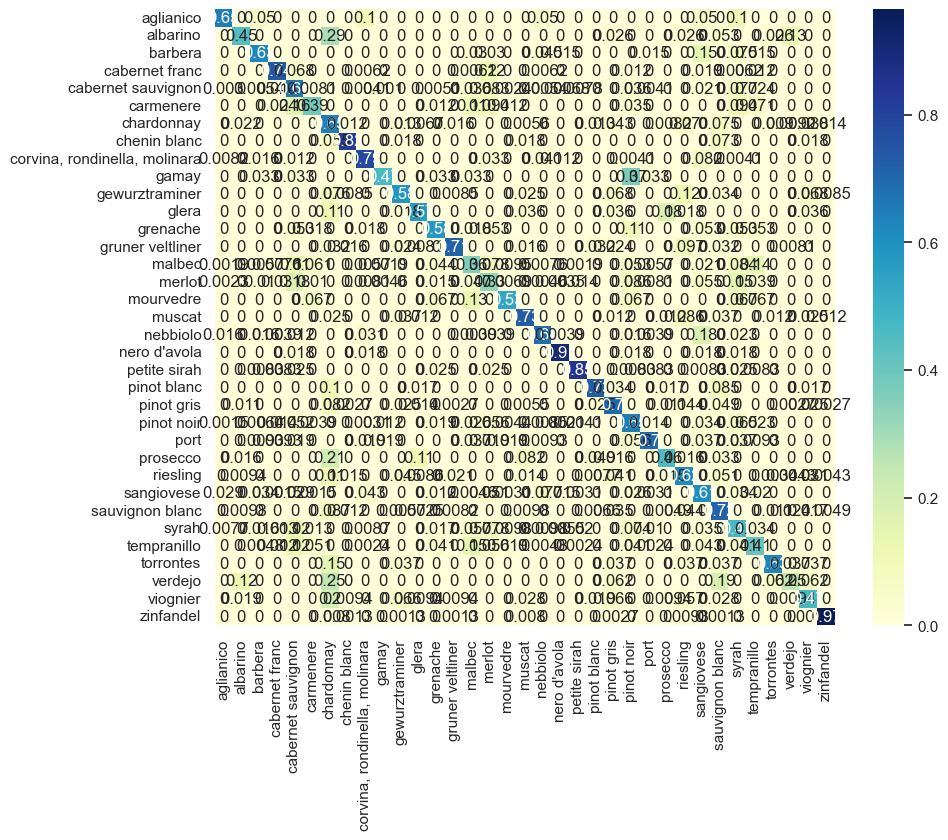

In [107]:
print_stats(y_test, preds, clf_test.classes_)

We still get an accuracy very close to the mean test accuracy on the validation set. 63% with a very simple classifier is not a bad deal. The preciosion for the target values that has not many samples are poor, but certainly there is hope for improvement. One could do a more thorough hyperparameter tuning or change to neural network classifiers.